In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.3 MB/s 
     |████████████████████████████████| 9.9 MB 15.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
from google.colab import files
upload = files.upload()

Saving air-quality-london-time-of-day.csv to air-quality-london-time-of-day.csv


In [3]:
from google.colab import files
upload = files.upload()

Saving air-quality-london-monthly-averages.csv to air-quality-london-monthly-averages.csv


## Two datasets are used in this application. The first, is London
##air quality in the form of a .csv file named air-quality-london-time-of-day.csv.
##The second, is a transformed version using average of the values across days
##to represent the value of one month, the latter is named air-quality-londonaverage.csv. 

#**1. Deal with missing entries in both datasets**

#1.1 air-quality-london-time-of-day.csv

In [4]:
data_path = 'air-quality-london-time-of-day.csv'
data = pd.read_csv(data_path,  header=0)


**Defining the data columns accordingly**

In [5]:
data.columns = ["Date","Time", 
             "RNO", "RNO2","RNOx","RO3","RPM10","RPM2.5","RSO2",
             "BNO", "BNO2","BNOx","BO3","BPM10","BPM2.5","BSO2"]
print("number of rows:", data.shape[0], "number of columns:", data.shape[1])
#data.head(10)

number of rows: 3336 number of columns: 16


#  Preprocessing

**The column "Date" should be named "Datetime". This is crucial since various approaches used in python to deal with time series require this particular naming.**

In [6]:
data.head()

,Date,Time,RNO,RNO2,RNOx,RO3,RPM10,RPM2.5,RSO2,BNO,BNO2,BNOx,BO3,BPM10,BPM2.5,BSO2
0,Jan-08,00:00,NaN,42.3,NaN,32.6,23.0,15.5,3.4,NaN,34.2,NaN,41.8,19.2,.,3.1
1,Jan-08,01:00,NaN,33.8,NaN,35.3,21.2,13.5,2.6,NaN,29.0,NaN,45.3,18.9,.,3.1
2,Jan-08,02:00,NaN,28.8,NaN,43.2,19.6,12.7,2.1,NaN,25.4,NaN,46.6,17.7,.,3.3
3,Jan-08,03:00,NaN,27.3,NaN,42.4,18.3,11.9,2.0,NaN,23.4,NaN,46.6,16.4,.,3.3
4,Jan-08,04:00,NaN,29.4,NaN,40.1,18.1,12.0,2.2,NaN,24.2,NaN,45.2,16.0,.,2.8


In [7]:
data.loc[:,'Datetime'] = data['Date'] + ' ' + data['Time']
data['Datetime']=pd.to_datetime(data.Datetime,  format='%b-%y %H:%M')
datetime = pd.Series(data.Datetime)
data.index = datetime
data.head()

,Date,Time,RNO,RNO2,RNOx,RO3,RPM10,RPM2.5,RSO2,BNO,BNO2,BNOx,BO3,BPM10,BPM2.5,BSO2,Datetime
Datetime,,,,,,,,,,,,,,,,,
2008-01-01 00:00:00,Jan-08,00:00,NaN,42.3,NaN,32.6,23.0,15.5,3.4,NaN,34.2,NaN,41.8,19.2,.,3.1,2008-01-01 00:00:00
2008-01-01 01:00:00,Jan-08,01:00,NaN,33.8,NaN,35.3,21.2,13.5,2.6,NaN,29.0,NaN,45.3,18.9,.,3.1,2008-01-01 01:00:00
2008-01-01 02:00:00,Jan-08,02:00,NaN,28.8,NaN,43.2,19.6,12.7,2.1,NaN,25.4,NaN,46.6,17.7,.,3.3,2008-01-01 02:00:00
2008-01-01 03:00:00,Jan-08,03:00,NaN,27.3,NaN,42.4,18.3,11.9,2.0,NaN,23.4,NaN,46.6,16.4,.,3.3,2008-01-01 03:00:00
2008-01-01 04:00:00,Jan-08,04:00,NaN,29.4,NaN,40.1,18.1,12.0,2.2,NaN,24.2,NaN,45.2,16.0,.,2.8,2008-01-01 04:00:00


In [8]:
data['BPM2.5'].replace('.', np.nan,inplace = True)

**To explore missing values in the data we use .isnull() in addition to .sum() to know the total missing values.**

##Display, in the form of a dataframe, the number of missing values in each feature

In [9]:
data.isnull().sum().sort_values().to_frame()

,0
Date,0
BPM10,0
BO3,0
BNO2,0
BSO2,0
RPM2.5,0
RSO2,0
RO3,0
RNO2,0
Time,0


**Five columns contain missing values: $500$ for RNO, RNOx, BNO, BNOx and $96$ for BPM2.5. One way to deal with missing values is to set a threshold beyond which all culomns should be dropped. In this case, we set the threshold = $10\%$ of the total data size.**

In [10]:
data.isnull().sum()/len(data)*100

Date         0.000000
Time         0.000000
RNO         17.266187
RNO2         0.000000
RNOx        17.266187
RO3          0.000000
RPM10        0.000000
RPM2.5       0.000000
RSO2         0.000000
BNO         17.266187
BNO2         0.000000
BNOx        17.266187
BO3          0.000000
BPM10        0.000000
BPM2.5       2.877698
BSO2         0.000000
Datetime     0.000000
dtype: float64

##Deleting features where the number of missing values exceed 10% of the total sample size

In [11]:
delete_columns = data.columns[data.isnull().sum()/len(data)*100 > 10]
delete_columns

Index(['RNO', 'RNOx', 'BNO', 'BNOx'], dtype='object')

**To drop said columns we use .drop() with inplace = True if the modification within the data is needed, otherwise it is set to False.**

In [12]:
data.drop(delete_columns, axis=1, inplace=True)

In [13]:
print("Number of rows:", data.shape[0], "Number of columns:", data.shape[1])
data['BPM2.5'] = data['BPM2.5'].astype(float)

Number of rows: 3336 Number of columns: 13


#1.2 - air-quality-london-monthly-averages.csv

In [14]:
data_pa = 'air-quality-london-monthly-averages.csv'
data2 = pd.read_csv(data_pa,  header=0)

In [15]:
data2.head(3)

,Month,London Mean Roadside:Nitric Oxide (ug/m3),London Mean Roadside:Nitrogen Dioxide (ug/m3),London Mean Roadside:Oxides of Nitrogen (ug/m3),London Mean Roadside:Ozone (ug/m3),London Mean Roadside:PM10 Particulate (ug/m3),London Mean Roadside:PM2.5 Particulate (ug/m3),London Mean Roadside:Sulphur Dioxide (ug/m3),London Mean Background:Nitric Oxide (ug/m3),London Mean Background:Nitrogen Dioxide (ug/m3),London Mean Background:Oxides of Nitrogen (ug/m3),London Mean Background:Ozone (ug/m3),London Mean Background:PM10 Particulate (ug/m3),London Mean Background:PM2.5 Particulate (ug/m3),London Mean Background:Sulphur Dioxide (ug/m3)
0,Jan-08,NaN,55.5,NaN,29.5,25.0,14.7,4.2,NaN,42.3,NaN,36.9,18.8,.,3.6
1,Feb-08,NaN,75.9,NaN,20.3,39.5,28.8,7.6,NaN,60.2,NaN,26.4,31.9,.,6.7
2,Mar-08,NaN,55.6,NaN,40.1,21.6,12.3,3.9,NaN,39.8,NaN,50.2,15.5,.,2.3


In [16]:
data2.columns = ["Date", 
             "RNO", "RNO2","RNOx","RO3","RPM10","RPM2.5","RSO2",
             "BNO", "BNO2","BNOx","BO3","BPM10","BPM2.5","BSO2"]

In [17]:
data2.shape

(139, 15)

In [18]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    139 non-null    object 
 1   RNO     115 non-null    float64
 2   RNO2    139 non-null    float64
 3   RNOx    115 non-null    float64
 4   RO3     139 non-null    float64
 5   RPM10   139 non-null    float64
 6   RPM2.5  139 non-null    float64
 7   RSO2    139 non-null    float64
 8   BNO     115 non-null    float64
 9   BNO2    139 non-null    float64
 10  BNOx    115 non-null    float64
 11  BO3     139 non-null    float64
 12  BPM10   139 non-null    float64
 13  BPM2.5  139 non-null    object 
 14  BSO2    139 non-null    float64
dtypes: float64(13), object(2)
memory usage: 16.4+ KB


In [19]:
data2.describe()

,RNO,RNO2,RNOx,RO3,RPM10,RPM2.5,RSO2,BNO,BNO2,BNOx,BO3,BPM10,BSO2
count,115.000000,139.000000,115.000000,139.000000,139.000000,139.000000,139.000000,115.000000,139.000000,115.000000,139.000000,139.000000,139.000000
mean,75.619130,55.210072,136.865217,27.314388,25.011511,15.603597,3.410072,21.397391,34.534532,55.563478,37.379137,19.241007,3.300000
std,29.784035,8.264656,33.090965,8.333237,5.210289,4.910583,1.819870,14.258906,8.611677,22.039073,11.514537,4.705236,1.005852
min,22.000000,34.900000,68.600000,10.700000,16.300000,7.900000,-1.700000,4.200000,18.400000,24.400000,13.900000,11.900000,1.100000
25%,56.150000,48.700000,114.500000,21.150000,21.450000,12.350000,2.400000,11.700000,27.800000,38.200000,29.100000,16.100000,2.650000
50%,70.600000,55.500000,129.300000,26.400000,23.800000,14.200000,3.300000,17.200000,33.700000,51.400000,36.600000,18.100000,3.200000
75%,98.800000,60.300000,159.850000,34.150000,27.900000,18.150000,4.100000,29.400000,40.850000,69.000000,46.550000,21.500000,4.000000
max,180.900000,75.900000,250.700000,46.300000,43.300000,32.600000,12.400000,79.200000,60.200000,129.200000,62.600000,36.900000,6.700000


In [20]:
print('Proportion of duplicates: {}%'.format(len(data2[data2.duplicated()])/data2.shape[0]*100))
#data2[data2.duplicated()] #check for average duplicate values in the dataset

Proportion of duplicates: 0.0%


###**Interpretation : The dataset has 15 columns and 139, this dataset is really small with 13 numeric and 2 object columns with no duplicate valuers.**

The column "Date" should be named "Datetime". This is crucial since various approaches used in python to deal with time series require this particular naming.

In [21]:
data2['Datetime'] = data2[['Date']] 
#data2['Datetime']=pd.to_datetime(data2.Datetime).dt.month
#data2.columns = data2.columns.str.strip()
data2['Datetime']  = pd.to_datetime(data2.Datetime, format='%b-%y')
#data2['Datetime'] =data2.close.resample(rule = "M").mean().ffill()
#datetime2 = pd.Series(data.Datetime)
data2.index = data2['Datetime'] 
#data2.head()
#datetime2 
data2

,Date,RNO,RNO2,RNOx,RO3,RPM10,RPM2.5,RSO2,BNO,BNO2,BNOx,BO3,BPM10,BPM2.5,BSO2,Datetime
Datetime,,,,,,,,,,,,,,,,
2008-01-01,Jan-08,NaN,55.5,NaN,29.5,25.0,14.7,4.2,NaN,42.3,NaN,36.9,18.8,.,3.6,2008-01-01
2008-02-01,Feb-08,NaN,75.9,NaN,20.3,39.5,28.8,7.6,NaN,60.2,NaN,26.4,31.9,.,6.7,2008-02-01
2008-03-01,Mar-08,NaN,55.6,NaN,40.1,21.6,12.3,3.9,NaN,39.8,NaN,50.2,15.5,.,2.3,2008-03-01
2008-04-01,Apr-08,NaN,61.8,NaN,37.9,28.7,20.5,4.5,NaN,44.0,NaN,50.1,21.7,.,3.2,2008-04-01
2008-05-01,May-08,NaN,62.9,NaN,46.3,34.6,27.5,4.6,NaN,44.1,NaN,60.5,29.5,16.6,4.3,2008-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-01,Mar-19,31.0,42.6,90.0,34.9,20.9,11.3,4.9,7.7,25.7,36.0,52.7,16.6,10.9,2.3,2019-03-01
2019-04-01,Apr-19,25.2,46.2,84.9,38.1,32.3,22.8,12.4,6.9,31.5,39.9,54.7,29.2,23.1,2.8,2019-04-01
2019-05-01,May-19,24.7,39.7,77.5,35.7,19.5,10.7,11.5,5.5,22.4,29.3,53.7,15.3,10.9,1.5,2019-05-01


#Display, in the form of a dataframe, the number of missing values in each feature

In [22]:
data2.isnull().sum().sort_values().to_frame()

,0
Date,0
RNO2,0
RO3,0
RPM10,0
RPM2.5,0
RSO2,0
BNO2,0
BO3,0
BPM10,0
BPM2.5,0


###**interpretation : 4 columns RNO, RNOX, BNO, BNOx continent 24 missing values for each. To do this we will try to measure the percentage of missing value per column and will select the columns in which missing values exceed 10%.**

In [23]:

pd.DataFrame(data = [data2.isnull().sum()/len(data)*100],
             index=["Null (%)"]).T.style.background_gradient(cmap='summer_r')

,Null (%)
Date,0.000000
RNO,0.719424
RNO2,0.000000
RNOx,0.719424
RO3,0.000000
RPM10,0.000000
RPM2.5,0.000000
RSO2,0.000000
BNO,0.719424
BNO2,0.000000


In [24]:
delete_columns = data2.columns[data2.isnull().sum()/len(data)*100 > 10]
delete_columns

Index([], dtype='object')

###**Interpretation: we can see the absence of the columns that have more than 1 to 3% of missing value. For this purpose, I will eliminate the missing value in the columns in question**.

In [25]:
print(f"Dataset has {data2.duplicated().sum()} duplicated data")

Dataset has 0 duplicated data


## **Data Visualization**

**Many Time Series visualization approaches exist. Here, we use two namely, boxplot and heatmap. The former is to observe each feature in terms of outliers and variance. The latter is a color coded matrix outlining the corrolation between the variables.**

#**1.1 air-quality-london-time-of-day.csv**

In [26]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


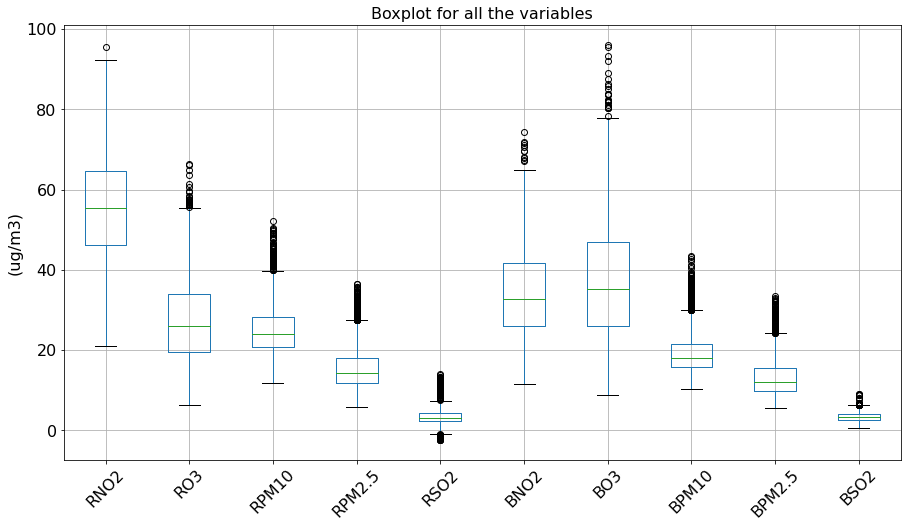

In [27]:
boxplot = data.boxplot( figsize=(15, 8), rot=45, fontsize=16)
plt.title('Boxplot for all the variables',fontsize=16)
plt.ylabel('(ug/m3)', fontsize=16)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b9d66d9a0>,
      dtype=object)

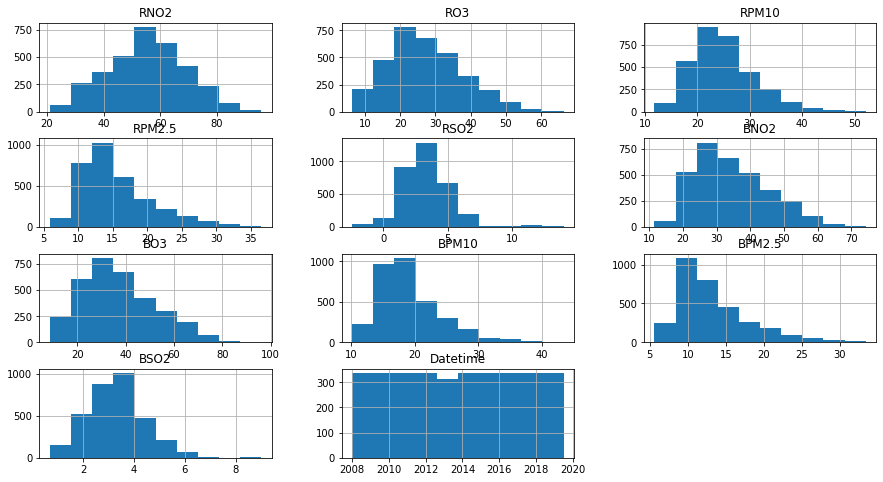

In [29]:
data.hist(figsize=(15, 8))

###**interpretation: I notice that almost all the columns have the appearance of a normal distribution**.

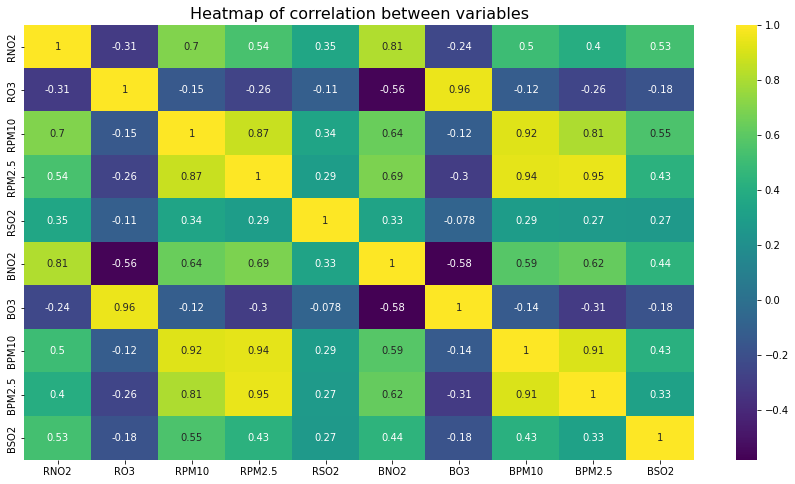

In [30]:
rcParams['figure.figsize']=15,8
sns.heatmap(data.corr(),annot=True,cmap='viridis')
plt.title('Heatmap of correlation between variables',fontsize=16)
plt.show()

# Calculate and sort the correlation values.

In [31]:
correlations_data = data.corr()['RO3'].sort_values()
correlations_data

BNO2     -0.563911
RNO2     -0.308505
RPM2.5   -0.263575
BPM2.5   -0.259265
BSO2     -0.176640
RPM10    -0.148450
BPM10    -0.122588
RSO2     -0.108712
BO3       0.955920
RO3       1.000000
Name: RO3, dtype: float64

In [32]:
df = pd.DataFrame({'O3':data.RO3})
df.to_csv('df_clean.csv')

In addition to the aforemensioned visualization techniques, the **line graph** is a classic one, observing directly the behavior of the time series at hand.

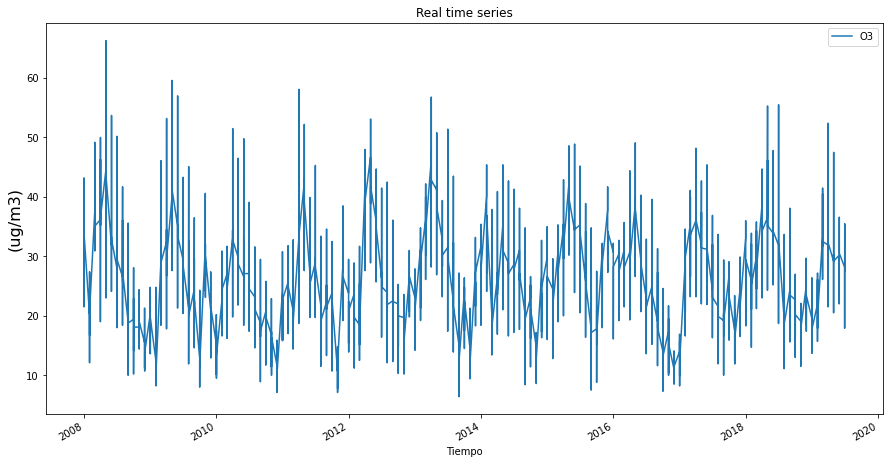

In [33]:
df_O3 = df[["O3"]].copy()
df_O3.plot()
plt.title('Real time series')
plt.xlabel('Tiempo')
plt.ylabel('(ug/m3)', fontsize=16)
plt.savefig('real.png')
plt.show()

#**1.2 - air-quality-london-monthly-averages.csv**

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


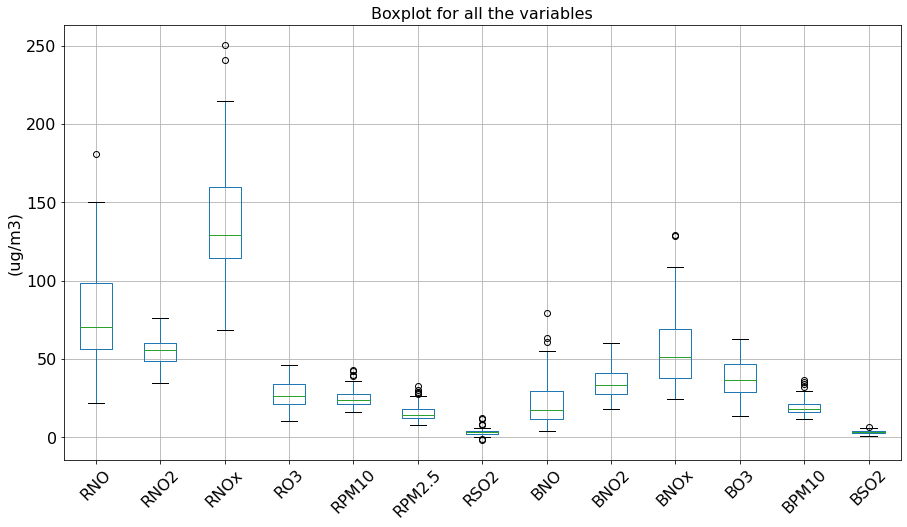

In [34]:
boxplot = data2.boxplot( figsize=(15, 8), rot=45, fontsize=16)
plt.title('Boxplot for all the variables',fontsize=16)
plt.ylabel('(ug/m3)', fontsize=16)
plt.show()

###**Interpretation: I notice the existence of some outliers for ROL10, RSO2.5, BPM10. So, I can think about the normalization to decrease the effect of these outliers.**

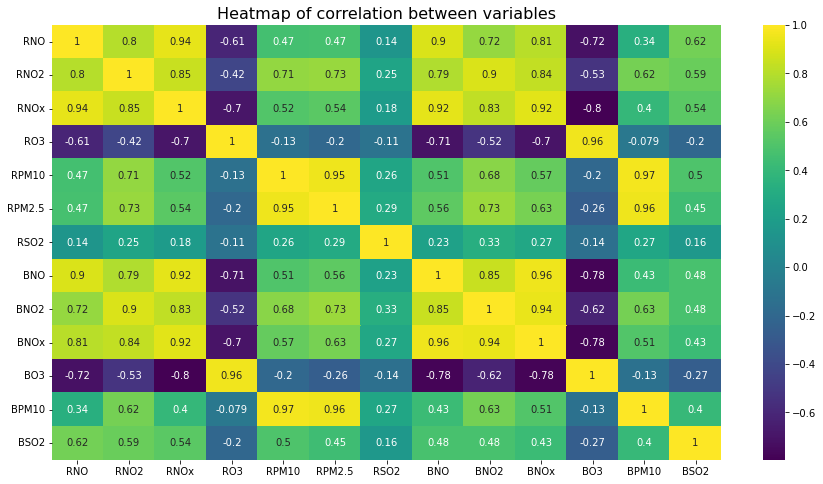

In [35]:
rcParams['figure.figsize']=15,8
sns.heatmap(data2.corr(),annot=True,cmap='viridis')
plt.title('Heatmap of correlation between variables',fontsize=16)
plt.show()

In [36]:
correlations_data = data2.corr()['RO3'].sort_values()
correlations_data

BNO      -0.706648
BNOx     -0.703966
RNOx     -0.695071
RNO      -0.612674
BNO2     -0.524205
RNO2     -0.418584
BSO2     -0.201294
RPM2.5   -0.196922
RPM10    -0.134191
RSO2     -0.111672
BPM10    -0.079428
BO3       0.962091
RO3       1.000000
Name: RO3, dtype: float64

###**interpretation: I find a strong positive correlation between the target variable and BO3.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b9a8d9400>,
      dtype=object)

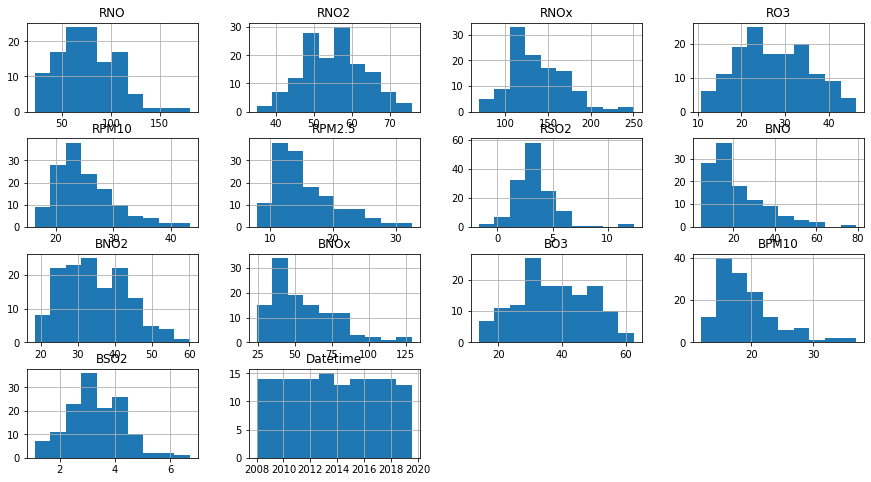

In [37]:
data2.hist(figsize=(15, 8))

###**interpretation: I notice that almost all the columns look like a normal distribution**.

In [38]:
df2 = pd.DataFrame({'O3':data2.RO3})
df2.to_csv('df2_clean.csv')

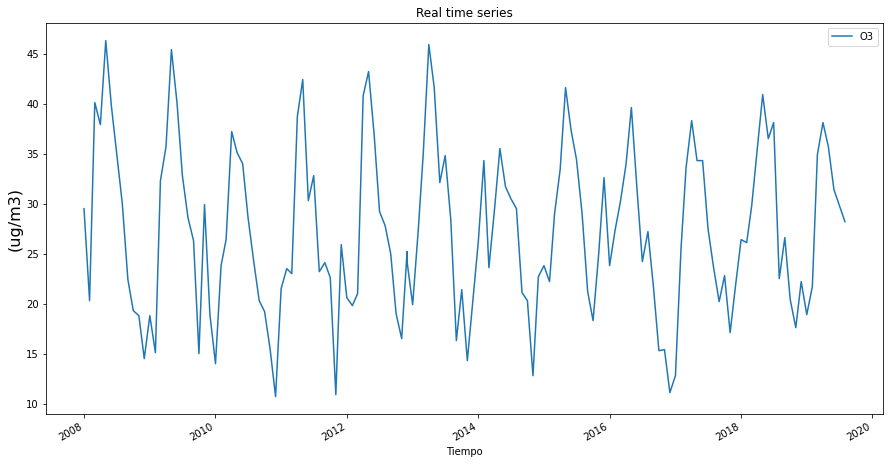

In [39]:
df2_O3 = df2[["O3"]].copy()
df2_O3.plot()
plt.title('Real time series')
plt.xlabel('Tiempo')
plt.ylabel('(ug/m3)', fontsize=16)
plt.savefig('real.png')
plt.show()


## **2)  Use the necessary Exploratory Data Analysis techniques of the target variable to check the following: Autocorrelation ,Seasonality , Stationarity.**

In this section a typical ARIMA model is constructed. In this case, we will transform our data from daily to monthly using resample with rule = 'M'

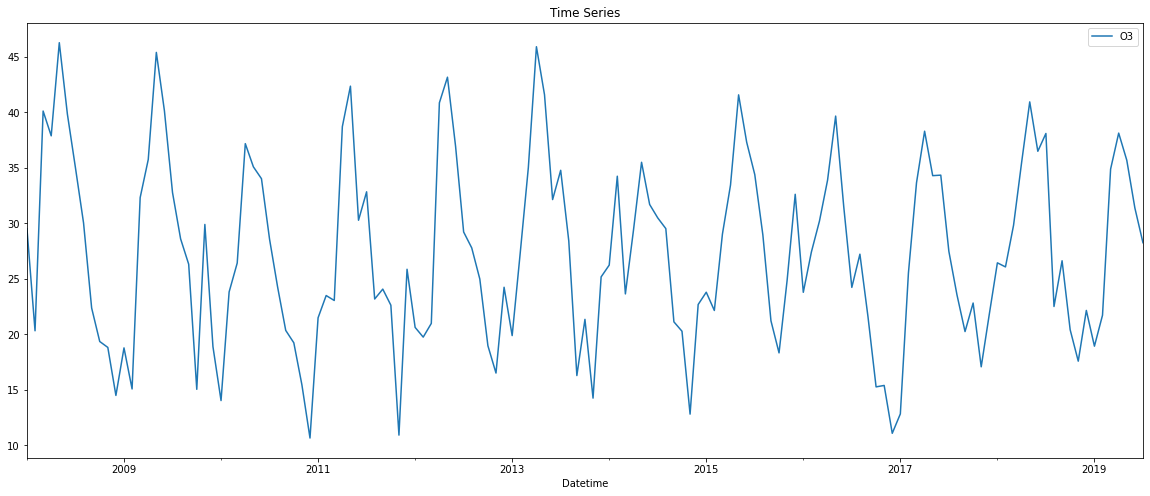

In [40]:
df_o3_resample = df_O3.resample(rule = "M").mean().ffill()
df_o3_resample.plot(figsize = (20,8))
plt.title("Time Series")
plt.savefig('serie.png')
plt.legend()
plt.show()

To check the Time Series components, namely, Trend, seasonal and Random. To do so, we use seasonal_decompose from statsmodels.tsa.seasonal.

In [41]:
import statsmodels
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

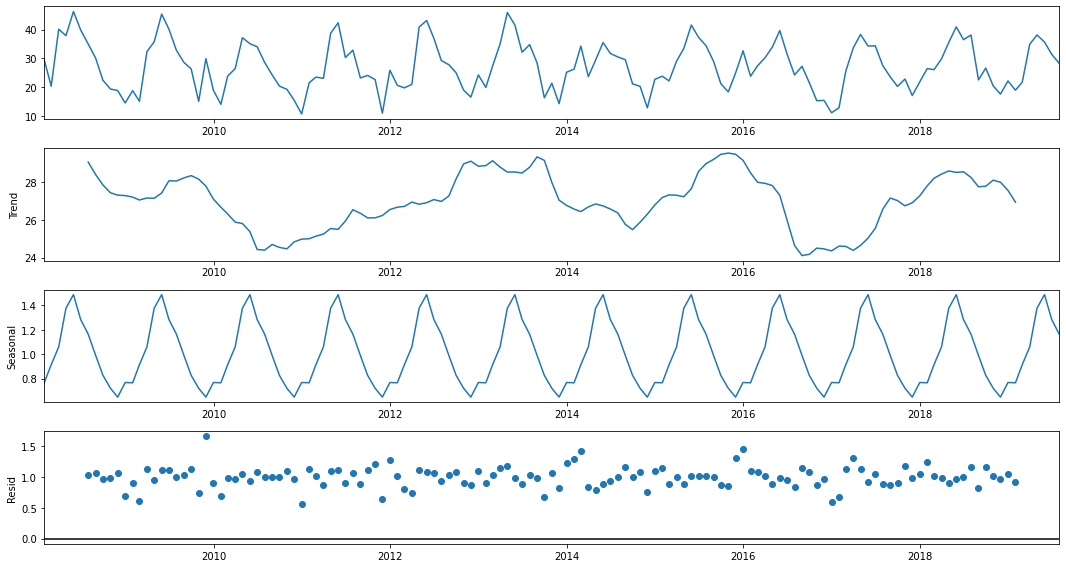

In [42]:
result = seasonal_decompose(df_o3_resample, model = "multiplicative") 
fig = result.plot()
plt.savefig('seasonal_decompose.png')
plt.show()

#**- stationarity**

Checking for stationarity using adfuller test for the first dataset

In [43]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_o3_resample["O3"])
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("Strong evidence against the null hypothesis, reject the null hypothesis. The data have no unit root and are stationary.")
else:
    print("Weak evidence against the null hypothesis, the time series has a unit root, indicating that it is not stationary.")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.714096642104887
p-value : 0.07163053862627902
#Lags Used : 11
Number of Observations Used : 127
Weak evidence against the null hypothesis, the time series has a unit root, indicating that it is not stationary.


#**- Autocorrelation**

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


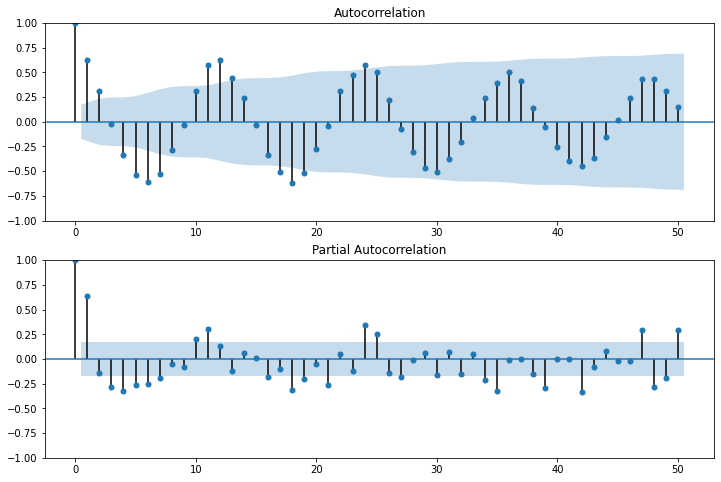

In [44]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_o3_resample["O3"].iloc[13:], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_o3_resample["O3"].iloc[13:], lags=50, ax=ax2)
plt.savefig('correlation.png')
plt.show()

## Autocorrelation Function (ACF)
Use the autocorrelation function (ACF) to identify which lags have significant correlations, understand the patterns and properties of the time series, and then use that information to model the time series data. From the ACF, you can assess the randomness and stationarity of a time series. You can also determine whether trends and seasonal patterns are present.

In an ACF plot, each bar represents the size and direction of the correlation. Bars that extend across the red line are statistically significant.

## Partial Autocorrelation Function (PACF)
The partial autocorrelation function is similar to the ACF except that it displays only the correlation between two observations that the shorter lags between those observations do not explain. For example, the partial autocorrelation for lag 3 is only the correlation that lags 1 and 2 do not explain. In other words, the partial correlation for each lag is the unique correlation between those two observations after partialling out the intervening correlations.


In [45]:
from statsmodels.tsa.stattools import acf

result = acf(df_o3_resample["O3"])

print('the P-value for the acf test is:'+str(result[3]))   


the P-value for the acf test is:-0.006661956505214724


/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


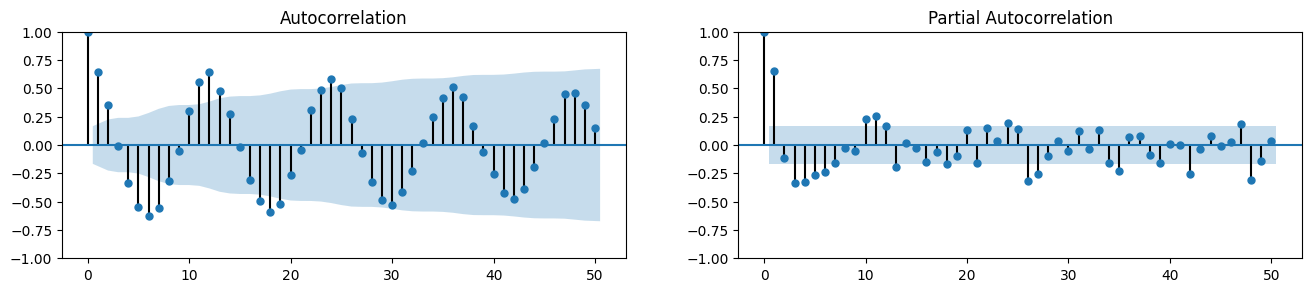

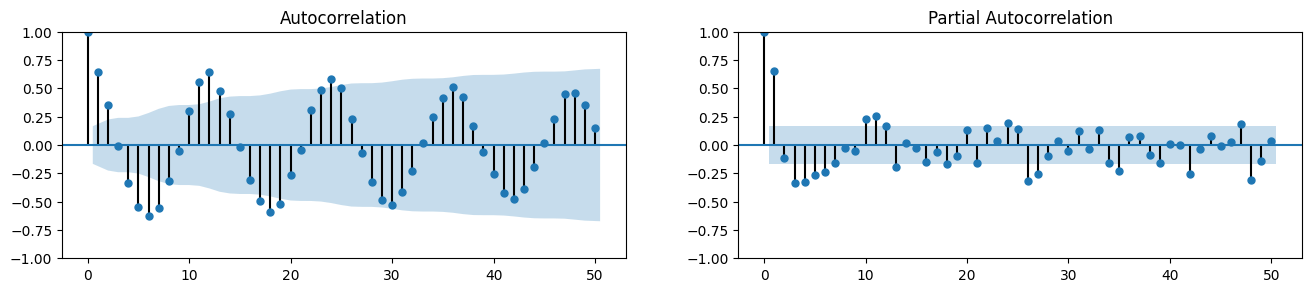

In [46]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



acf_50 = acf(df_o3_resample["O3"], nlags=50)
pacf_50 = pacf(df_o3_resample["O3"], nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df_o3_resample["O3"].tolist(), lags=50, ax=axes[0])
plot_pacf(df_o3_resample["O3"].tolist(), lags=50, ax=axes[1])

###**Interpretation: there is a strong correlation of the series with its previous values so we must try to make it stationary to counteract the autocorrelation and favor the prediction because the prediction of a stationary series is  relatively easy and the forecasts are more reliable because its means, variances, and covariances that change over time and to make it stationary we can use We can apply some sort of transformation to make the time-series stationary. These transformation may include:**
- Differencing the Series (once or more)
- Take the log of the series
- Take the nth root of the series
- Combination of the above

#**-Seasonality**

###from the plot of the seasonal_decompose I can see one seasonality per year, so I will try to extract more parameters using this seasonality factor, the method I will use is the one from statsmodels.tsa.deterministic.saesonality and CalendarFourier, DeterministicProcess 

##**- CalendarFourier, DeterministicProcess**

In [47]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
y = df_o3_resample.copy()

fourier = CalendarFourier(freq='A', order=4)
dp = DeterministicProcess(
    index=y.index, # dates from the training data
    constant=True,# dummy feature for the bias (y_intercept)
    order=0, # the time dummy (trend)
    seasonal=True,
    additional_terms=[fourier],
    drop=True,# drop terms if necessary to avoid collinearit
)
X = dp.in_sample()
X


,const,"s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)","s(10,12)","s(11,12)","s(12,12)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)"
Datetime,,,,,,,,,,,,,,,,,,,,
2008-01-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.492548,0.870285,0.857315,0.514793,0.999668,0.025748,0.882679,-0.469977
2008-02-29,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.848351,0.529434,0.898292,-0.439400,0.102821,-0.994700,-0.789418,-0.613856
2008-03-31,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999668,0.025748,0.051479,-0.998674,-0.997018,-0.077175,-0.102821,0.994700
2008-04-30,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.882679,-0.469977,-0.829677,-0.558244,-0.102821,0.994700,0.926324,-0.376728
2008-05-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.522133,-0.852864,-0.890617,0.454755,0.997018,0.077175,-0.810025,-0.586396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-31,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999250,0.038722,0.077386,-0.997001,-0.993257,-0.115935,-0.154309,0.988023
2019-04-30,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888057,-0.459733,-0.816538,-0.577292,-0.137279,0.990532,0.942761,-0.333469
2019-05-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.530730,-0.847541,-0.899631,0.436651,0.994218,0.107381,-0.785650,-0.618671


In [48]:
dp.out_of_sample(4)

,const,"s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)","s(10,12)","s(11,12)","s(12,12)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)"
2019-08-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.854322,-0.519744,0.888057,-0.459733,-0.068802,0.997630,-0.816538,-0.577292
2019-09-30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.999546,-0.030120,0.060213,-0.998186,0.995919,0.090252,-0.120208,0.992749
2019-10-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.875892,0.482508,-0.845249,-0.534373,0.060213,-0.998186,0.903356,-0.428892
2019-11-30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.523416,0.852078,-0.891981,0.452072,-0.996659,-0.081676,-0.806480,-0.591261


##**- statsmodels.tsa.deterministic.Seasonality**

In [49]:
from statsmodels.tsa.deterministic import Seasonality
seas_gen = Seasonality(12, initial_period=4)
seas_gen.in_sample(y.index)

,"s(1,12)","s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)","s(10,12)","s(11,12)","s(12,12)"
Datetime,,,,,,,,,,,,
2008-01-31,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-02-29,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-03-31,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-04-30,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2008-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-31,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-30,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#**3. Log-transform the average dataset followed by one unit shift. Answer question (1) and (2) on the new target variable, discuss.**

In [50]:
df_o3_resample["O3_log"]=np.log(df_o3_resample["O3"])
df_o3_resample["O3_log_diff"] =df_o3_resample["O3_log"]-df_o3_resample["O3_log"].shift(1)

In [51]:
result = adfuller(df_o3_resample["O3_log_diff"].dropna(inplace=False))
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("Strong evidence against the null hypothesis, reject the null hypothesis. The data have no unit root and are stationary.")
else:
    print("Weak evidence against the null hypothesis, the time series has a unit root, indicating that it is not stationary.")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -6.736308965549323
p-value : 3.2009968577555725e-09
#Lags Used : 12
Number of Observations Used : 125
Strong evidence against the null hypothesis, reject the null hypothesis. The data have no unit root and are stationary.


/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


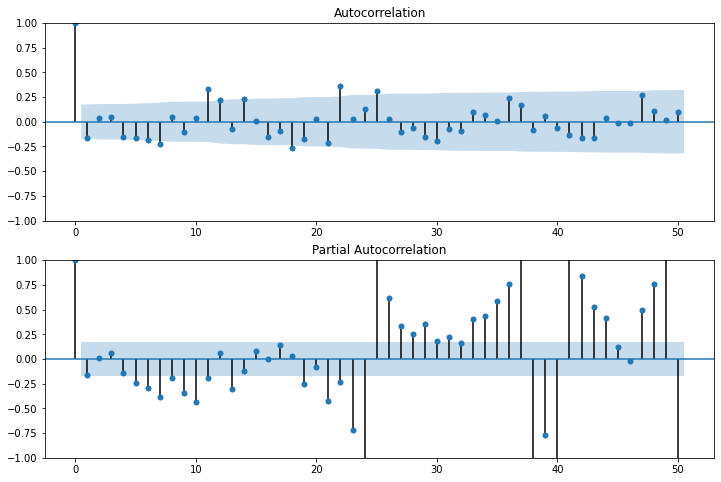

In [52]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_o3_resample["O3_log_diff"].iloc[13:], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_o3_resample["O3_log_diff"].iloc[13:], lags=50, ax=ax2)
plt.savefig('correlation.png')
plt.show()

###**interpretation: this time I made my data stationary by using Differencing the Series (once or more)**

#**4. Split the data into training and testing data, where testing data contains the last 12 months’ observations. Use a method of your choice to tune the parameters p, q and d in order to use ARIMA model for forecasting.**

ARMA and ARIMA architectures are just the $AR$ (Auto-Regressive) and $MA$ (Moving Average) components put together. The ARMA model is a constant plus the sum of $AR$ lags and their multipliers, plus the sum of the $MA$ lags and their multipliers plus white noise. This equation is the basis of all the models that come next and is a framework for many forecasting models across different domains.
$$\boldsymbol{Y}_i = A_0 +\sum\limits^{p}_{n=1} A_n \boldsymbol{Y}_{i-n}+ \sum\limits^{q}_{n=1} B_n \delta_{i-n} + \delta_i$$
$$\boldsymbol{Y}_i = A_0 + A_1 \boldsymbol{Y}_{i-1} + \cdots + A_p \boldsymbol{Y}_{i-p} + \theta_1 \delta_{i-1} + \cdots+ \theta_q \delta_{i-q} +\delta_i$$
The ARIMA model is an ARMA model yet with a preprocessing step included in the model that we represent using $I(d)$. $I(d)$ is the difference order, which is the number of transformations needed to make the data stationary. So, an ARIMA model is simply an ARMA model on the differenced time series.

## The parameters $p$, $q$ and $d$ should be tuned before training the model. To do so we will use the **auto_arima**

In [53]:
# Import the library 
from pmdarima import auto_arima 
  
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function   
stepwise_fit = auto_arima(df_o3_resample["O3_log_diff"].dropna(inplace=False),start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1,  
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)

In [54]:
# To print the summary 
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  138
Model:             SARIMAX(3, 0, 1)x(2, 1, 1, 12)   Log Likelihood                   9.159
Date:                            Tue, 20 Dec 2022   AIC                             -0.319
Time:                                    21:46:02   BIC                             25.208
Sample:                                02-29-2008   HQIC                            10.052
                                     - 07-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.302      0.763      -0.001       0.001
ar.L1          0.0740      0.093      0.793      0.428      -0.109       0.257
ar.L2          0.1158      0.122      0.951      0.341      -0.123       0.354
ar.L3          0.0633      0.122      0.520      0.603      -0.175       0.302
ma.L1         -0.9691      0.092    -10.545      0.000      -1.149      -0.789
ar.S.L12      -0.0391      0.271     -0.144      0.885      -0.570       0.492
ar.S.L24       0.0154      0.208      0.074      0.941      -0.393       0.424
ma.S.L12      -0.6715      0.226     -2.976      0.003      -1.114      -0.229
sigma2         0.0459      0.006      7.179      0.000       0.033       0.058
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                13.09
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.33
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

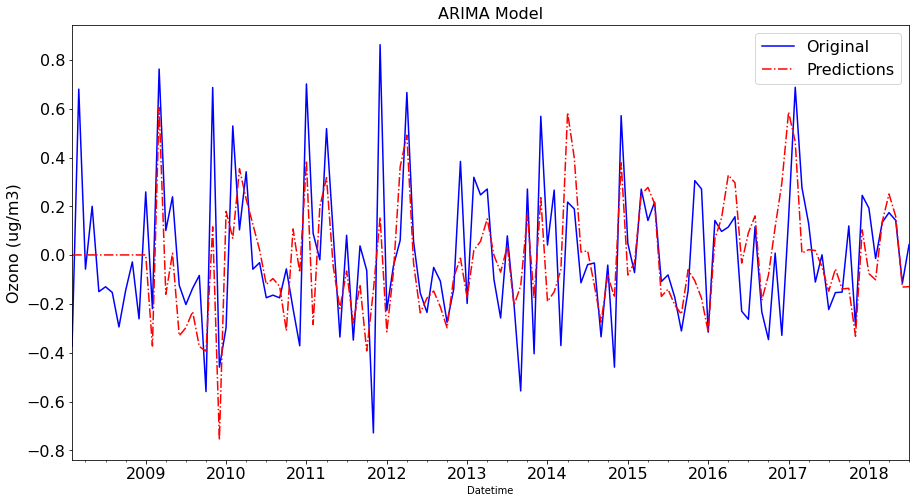

In [55]:
df_o3_resample.dropna(inplace=True)
# Split data into train / test sets 
train = df_o3_resample.iloc[:len(df_o3_resample["O3_log_diff"])-12] 
test = df_o3_resample.iloc[len(df_o3_resample["O3_log_diff"])-12:] # set one year(12 months) for testing 

from statsmodels.tsa.statespace.sarimax import SARIMAX 

model = SARIMAX(train['O3_log_diff'], 
				order=(0,0,1), 
				seasonal_order=(0,1,1,12),   
				trend='c'			
				) 

result = model.fit() 
result.summary() 
start = len(train) 
end = len(train) + len(test) - 1

# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
							typ = 'levels').rename("Predictions")
# plot predictions and actual values 
train['O3_log_diff'].plot(label='Original', color='blue', fontsize=16) 
result.fittedvalues.plot( label='Predictions', color='red', fontsize=16, ls='-.', figsize=(15,8))
plt.ylabel("Ozono (ug/m3)", fontsize=16)
plt.title("ARIMA Model", fontsize=16)
plt.legend(loc=1, prop={'size': 16})
plt.show()

# **Plotting Predition and real data.**

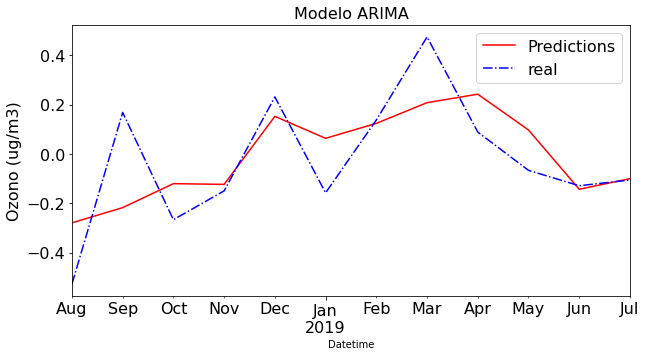

In [56]:
predictions.plot( color ='red', label='Predictions', figsize = (10,5), fontsize=16) 
test['O3_log_diff'].plot(color = 'blue', ls='-.', label='real',fontsize=16) 
plt.ylabel("Ozono (ug/m3)", fontsize=16)
plt.title("Modelo ARIMA", fontsize=16)
plt.legend(loc=1, prop={'size': 16})
plt.show()

###**Interpretation: the prediction results are relatively good but they can be improved by using deep learning models like RNN and LSTM.**

#**5. Use SSE and RMSE errors to assess the model’s performance.**

**Evaluation of the model using MAE, MSE and RMSE.**

In [57]:
print('MAE:', metrics.mean_absolute_error(test["O3_log_diff"], predictions))
print('MSE:', metrics.mean_squared_error(test["O3_log_diff"], predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test["O3_log_diff"], predictions)))

MAE: 0.14335457176946037
MSE: 0.03398838539575293
RMSE: 0.1843593919380104


#**- I'm going to use another statistical algorithm as a comparison that prophets.**


##Prophet is an additional regression model in the form of a logistic or linear growth trend curve. 

In [58]:
from prophet import Prophet

In [59]:
a=df_o3_resample["O3_log_diff"].to_frame()

In [60]:
a['ds']=a.index

In [62]:
aa=a.reset_index(drop=True)

In [64]:
aa.rename(columns={'ds':'ds','O3_log_diff':'y'},inplace=True)

In [66]:
train_pro = aa.iloc[:len(aa)-12] 
test_pro = aa.iloc[len(aa)-12:] # set one year(12 months) for testing 

prophet_basic = Prophet()
result_pro= prophet_basic.fit(train_pro)


# Predictions for one-year against the test set 
futur=result_pro.make_future_dataframe(periods=12)
predictions=result_pro.predict(futur)

predictions

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppysjkp59/kw3ga_zp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppysjkp59/n9mnqvpm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9332', 'data', 'file=/tmp/tmppysjkp59/kw3ga_zp.json', 'init=/tmp/tmppysjkp59/n9mnqvpm.json', 'output', 'file=/tmp/tmppysjkp59/prophet_model_0fnc76c/prophet_model-20221220215109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:51:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:51:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-02-29,-0.017494,-0.217280,0.448498,-0.017494,-0.017494,0.120412,0.120412,0.120412,0.120412,0.120412,0.120412,0.0,0.0,0.0,0.102918
1,2008-03-31,-0.017227,-0.135957,0.490174,-0.017227,-0.017227,0.210937,0.210937,0.210937,0.210937,0.210937,0.210937,0.0,0.0,0.0,0.193711
2,2008-04-30,-0.016968,-0.114626,0.540491,-0.016968,-0.016968,0.240106,0.240106,0.240106,0.240106,0.240106,0.240106,0.0,0.0,0.0,0.223138
3,2008-05-31,-0.016701,-0.228025,0.393793,-0.016701,-0.016701,0.099396,0.099396,0.099396,0.099396,0.099396,0.099396,0.0,0.0,0.0,0.082695
4,2008-06-30,-0.016442,-0.476632,0.153339,-0.016442,-0.016442,-0.145324,-0.145324,-0.145324,-0.145324,-0.145324,-0.145324,0.0,0.0,0.0,-0.161766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,2018-08-08,0.015350,-0.497025,0.146440,0.015350,0.015350,-0.194582,-0.194582,-0.194582,-0.194582,-0.194582,-0.194582,0.0,0.0,0.0,-0.179232
134,2018-08-09,0.015358,-0.516817,0.108404,0.015358,0.015358,-0.203941,-0.203941,-0.203941,-0.203941,-0.203941,-0.203941,0.0,0.0,0.0,-0.188583
135,2018-08-10,0.015367,-0.521267,0.117597,0.015367,0.015367,-0.212137,-0.212137,-0.212137,-0.212137,-0.212137,-0.212137,0.0,0.0,0.0,-0.196770
136,2018-08-11,0.015376,-0.541103,0.113811,0.015376,0.015376,-0.219058,-0.219058,-0.219058,-0.219058,-0.219058,-0.219058,0.0,0.0,0.0,-0.203682


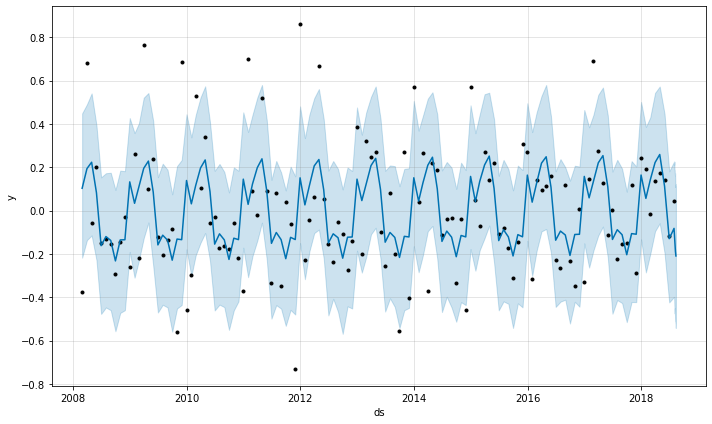

In [67]:
result_pro.plot(predictions)

plt.show()

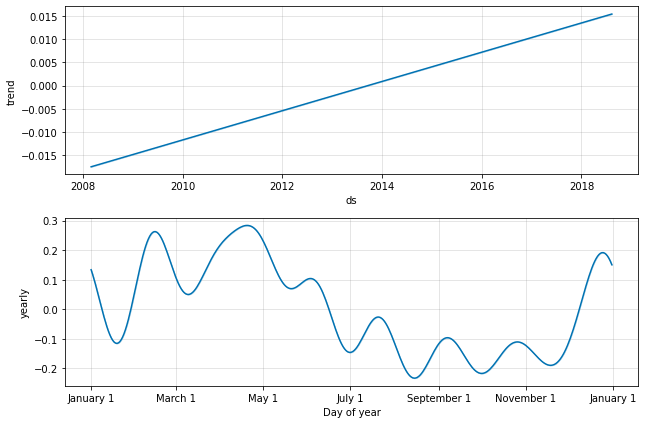

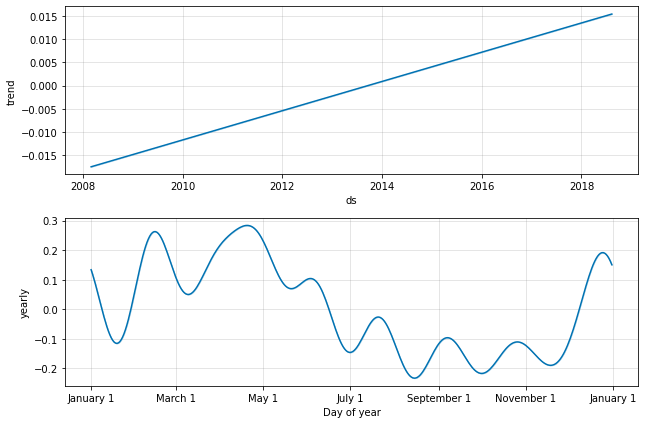

In [68]:
 result_pro.plot_components(predictions)

###**Interpretation: the prophet model is more advanced and developed than ARIMA. For this reason it offers more accurate predictions.**